In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm,kstest,shapiro,t
import pylab
import time
import warnings
import seaborn as sns

## Problem 1 
Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.

Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it.

Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λ chosen.

What does this tell us about values of λ and the effect it has on the covariance matrix?


In [3]:
df = pd.read_csv("./DailyReturn.csv")
df = df.drop(axis = 1,labels = "Unnamed: 0")

In [4]:
lamb = [0.1, 0.2, 0.5, 0.75, 0.90, 0.97, 0.99]
weights = []
X = df.index.values
for w in lamb:
    weights.append([(1-w)*w**(i-1) for i in X])
    
# the number of weight is not infinite, so we need to adjust the sum of weights equal to 1
weights_adj = np.zeros((len(weights),len(df)))
for i in range(len(weights)):
    for j in range(len(df)):
        weights_adj[i][j] = weights[i][j] /sum(weights[i])
    #print(sum(weights_adj[i]))

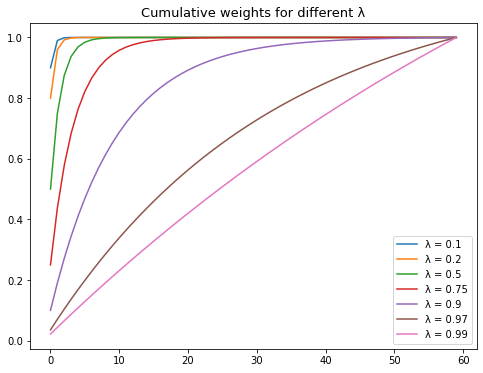

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(len(lamb)):
    ax.plot(X, np.array(weights_adj[i]).cumsum(),label = f"λ = {lamb[i]}")
ax.legend(loc='best')
ax.set_title("Cumulative weights for different λ", fontsize=13)
plt.show()

In [6]:
# calculate the covariance
    
def weighted_pair(x, y, weight):
    n = len(weight)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    cov = 0
    for i in range(n):
        cov += weight[n - 1 - i]*(x[i] - mean_x) * (y[i] - mean_y)
    return cov

def calculate_weight(lamb, df):
    X = df.index.values
    weight = [(1-lamb)*lamb**(i-1) for i in X]
    weight_adjust = [weight[i]/sum(weight) for i in X]
    return weight_adjust

def weighted_cov(lamb, df):

    n = df.shape[1]
    T = len(df)
    weight = calculate_weight(lamb, df)
    cov_mat = pd.DataFrame(np.zeros((n, n)))
    for i in range(n):
        x = df.iloc[:, i]
        cov_mat.iloc[i, i] = weighted_pair(x, x, weight)
        for j in range(i+1):
            y = df.iloc[:, j]
            cov_mat.iloc[i, j] = weighted_pair(x, y, weight)
            cov_mat.iloc[j, i] = cov_mat.iloc[i, j]

    return np.array(cov_mat)

Text(0.5, 1.0, 'pct Explainded for different λ')

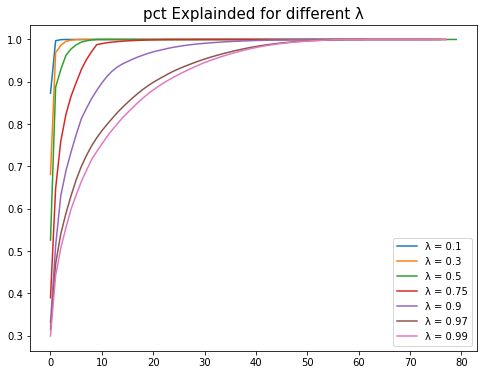

In [7]:
def PCA(cov_matrix):
    eigenvalue, eigenvector = np.linalg.eigh(cov_matrix)
    eigenvalue = sorted(eigenvalue, reverse = True)
    total_eigen = np.sum(eigenvalue)
    explain = 0
    pctExplained_list = []
    
    for i in range(len(eigenvalue)):
        if eigenvalue[i] < 0:
            break
        explain += eigenvalue[i]
        pctExplained_list.append(explain/total_eigen)
    return np.array(pctExplained_list)


lamb = [0.1, 0.3, 0.5, 0.75, 0.90, 0.97, 0.99]
fig, ax = plt.subplots(figsize=(8,6))

for la in lamb:
    cov_mat = weighted_cov(la, df)
    PCA_list = PCA(cov_mat)
    ax.plot(PCA_list, label = f"λ = {la}")
ax.legend(loc='best')
ax.set_title("pct Explainded for different λ", fontsize=15)

# Problem2
Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice. These are core functions you will need throughout the remainder of the class.

Implement Higham’s 2002 nearest psd correlation function.

Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:
```
n = 500
sigma = fill(0.9,(n,n))
for i in 1:n
    sigma[i][i]=1.0
end
sigma[1,2]=0.7357
sigma[2,1]=0.7357
```
Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD. Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases? Based on the above, discuss the pros and cons of each method and when you would use each. There is no wrong answer here, I want you to think through this and tell me what you think.

## implement the Cholesky Fatoriaztion algorithm

In [8]:
def chol_psd(A):
    """Performs a Cholesky decomposition of a matrix, the matrix 
    should be a symmetric and PD matrix.
    return: the lower triangle matrix."""
    n = len(A)

    # Create zero matrix for L
    L = np.array([[0.0] * n for _ in range(n)])

    # Perform the Cholesky decomposition
    for j in range(n):
        s = L[j,:j]@L[j,:j].T
        #Diagonal Element
        temp = A[j,j] - s
        if 0 >= temp >= -1e-8:
            temp = 0.0

        elif temp < -1e-8:
            raise ValueError("The matrix is non-PSD!")
        L[j,j] = np.sqrt(temp);
        #Check for the 0 eigan value.  Just set the column to 0 if we have one
        if L[j,j] == 0:
            continue


        #non-Diagonal Element
        ir = 1.0/L[j,j]
        for i in range(j+1,n):
            s = L[i,:j]@L[j,:j]
            L[i,j] =(A[i,j] - s)*ir
    return L


In [9]:
#Test for my chol_psd function with np.linalg.cholesky function
A = np.array([[4, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
    
expected_L = np.linalg.cholesky(A)
chol_psd_L = chol_psd(A)

if abs(expected_L - chol_psd_L).sum() < 1e-8:
    print("Congrats! The chol_psd function shows the same solution with the cholesky function in numpy.")
    print(chol_psd_L)


Congrats! The chol_psd function shows the same solution with the cholesky function in numpy.
[[ 2.          0.          0.          0.        ]
 [ 1.5         1.93649167  0.          0.        ]
 [ 2.          1.03279556  2.22111083  0.        ]
 [ 4.         -2.5819889   0.75037528  1.33051504]]


## Find the nearest PSD matrix with Rebonato and Jackel method

In [10]:
def near_psd(A):
    """Find the nearest PSD matrix with Rebonato and Jackel method"""
    eig_val, eig_vec = np.linalg.eigh(A)
    # construct a new Λ that all eigen values >= 0
    eig_val[eig_val < 0] = 0.0
    t = 1/(eig_vec**2@eig_val)
    
    # construct the diagonal scaling matrix
    T_sqrt = np.diagflat(np.sqrt(t))
    la_sqrt = np.diagflat(np.sqrt(eig_val))

    # Let B = sqrt(T) * S * sqrt(Λ)
    B = T_sqrt@eig_vec@la_sqrt
    #the nearest matrix is C = B*B'
    return B@B.T
    

In [11]:
A_b = np.array([[-4, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
near_psd(A_b)

array([[1.        , 0.51367807, 0.74197534, 0.8955502 ],
       [0.51367807, 1.        , 0.64592377, 0.10010898],
       [0.74197534, 0.64592377, 1.        , 0.446701  ],
       [0.8955502 , 0.10010898, 0.446701  , 1.        ]])

## Implement Higham’s 2002 nearest psd correlation function.

In [12]:
def Frobenius_norm(A):
    n = len(A)
    s = 0
    for i in range(n):
        for j in range(n):
            s+=A[i,j]**2
    return s

def proj_u(A):
    corr_ = A.copy()
    np.fill_diagonal(corr_,1)
    return corr_

def proj_s(A):
    eig_val, eig_vec = np.linalg.eigh(A)
    eig_val[eig_val<0] = 0
    p = eig_vec@ np.diagflat(eig_val)@eig_vec.T
    return p


def Higham_near_psd(A):
    #∆𝑆0 = 0, 𝑌0 = 𝐴, γ0 = 𝑚𝑎𝑥 𝐹𝑙𝑜𝑎𝑡
    dS = 0
    Y = A
    last_gamma = float("inf")
    iteration = 100000
    tol = 1e-10
    #𝐿𝑜𝑜𝑝 𝑘 ∈ 1... 𝑚𝑎𝑥 𝐼𝑡𝑒𝑟𝑎𝑡𝑖𝑜𝑛𝑠 
    for i in range(iteration):
        R = Y - dS                       #𝑅𝑘 = 𝑌𝑘−1 − ∆𝑆𝑘−1 
        X = proj_s(R)                    #𝑋𝑘 = 𝑃𝑆(𝑅𝑘) 
        dS = X - R                       #∆𝑆𝑘 = 𝑋𝑘 − 𝑅𝑘 
        Y = proj_u(X)                    #𝑌𝑘 = 𝑃𝑈(𝑋𝑘) 
        gamma = Frobenius_norm(Y - A)    #γ𝑘 = γ(𝑌𝑘) 
        if abs(gamma-last_gamma)< tol:   #𝑖𝑓 γ𝑘−1 − γ𝑘 < 𝑡𝑜𝑙 𝑡ℎ𝑒𝑛 𝑏𝑟𝑒𝑎𝑘
            break
        last_gamma = gamma
    return Y



## Generate a non-psd correlation matrix 

In [13]:
def generate_nonpsd_matrix(n):
    corr = np.full((n,n),0.9)
    np.fill_diagonal(corr, 1)
    corr[0,1] = 0.7357
    corr[1,0] = 0.7357 
    return corr

corr = generate_nonpsd_matrix(500)
corr

array([[1.    , 0.7357, 0.9   , ..., 0.9   , 0.9   , 0.9   ],
       [0.7357, 1.    , 0.9   , ..., 0.9   , 0.9   , 0.9   ],
       [0.9   , 0.9   , 1.    , ..., 0.9   , 0.9   , 0.9   ],
       ...,
       [0.9   , 0.9   , 0.9   , ..., 1.    , 0.9   , 0.9   ],
       [0.9   , 0.9   , 0.9   , ..., 0.9   , 1.    , 0.9   ],
       [0.9   , 0.9   , 0.9   , ..., 0.9   , 0.9   , 1.    ]])

## Compare the algorithm
Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD. Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases? Based on the above, discuss the pros and cons of each method and when you would use each. There is no wrong answer here, I want you to think through this and tell me what you think.

In [14]:
import timeit
def Function_runtime(func,*args, **kwargs):
    start = timeit.default_timer()
    result = func(*args, **kwargs)
    
    stop = timeit.default_timer()
    time = stop-start
    return result, time


In [15]:
# NxN matrix
N = [10,20,50,100,200,300,400,500]

length = len(N)
Rebonato_Jackel_runtime = []
Higham_runtime = []
Rebonato_Jackel_Fnorm = []
Higham_Fnorm = []

for i in range(len(N)):
    nonpsd_mat = generate_nonpsd_matrix(N[i])
    # res1: the psd matrix calculated by Rebonato Jackel method
    # time1: the function run time by Rebonato Jackel method
    res1, time1 = Function_runtime(near_psd, nonpsd_mat)
    Rebonato_Jackel_runtime.append(time1)
    
    # calculate the Frobenuis Norm for Rebonato Jackel method
    norm1 = Frobenius_norm(res1 - nonpsd_mat)
    Rebonato_Jackel_Fnorm.append(norm1)
    
    # res2: the psd matrix calculated by Higham method
    # time2: the function run time by Higham method
    res2, time2 = Function_runtime(Higham_near_psd, nonpsd_mat)
    Higham_runtime.append(time2)
    # calculate the Frobenuis Norm for Higham method
    norm2 = Frobenius_norm(res2 - nonpsd_mat)
    Higham_Fnorm.append(norm2)
    


         Rebonato_Jackel_runtime  Higham_runtime
N = 10                  0.000284        0.001996
N = 20                  0.000145        0.004164
N = 50                  0.001203        0.031657
N = 100                 0.001450        0.129667
N = 200                 0.008652        0.582378
N = 300                 0.009076        1.190405
N = 400                 0.018615        2.030293
N = 500                 0.029628        3.301311
         Rebonato_Jackel_Fnorm  Higham_Fnorm
N = 10                0.002739      0.001519
N = 20                0.010530      0.003887
N = 50                0.034479      0.006189
N = 100               0.074415      0.007164
N = 200               0.154265      0.007699
N = 300               0.234106      0.007885
N = 400               0.313946      0.007980
N = 500               0.393785      0.008037


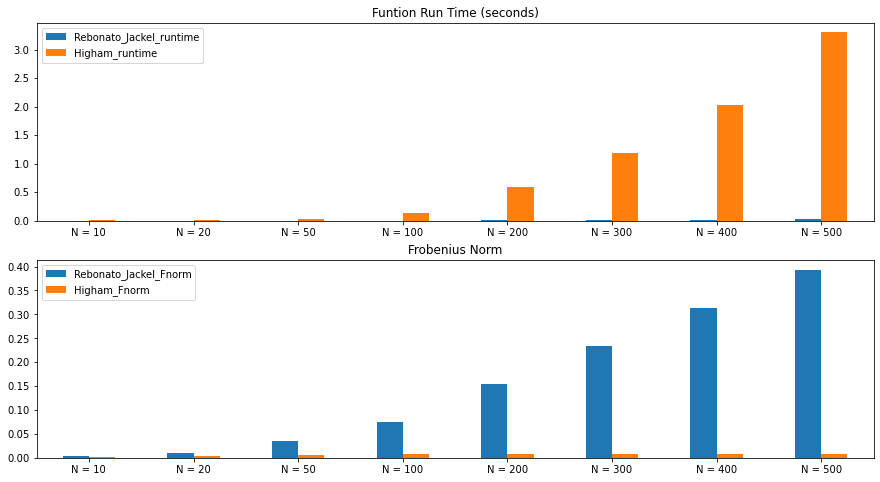

In [16]:
# plot the figures to demonstrate my conclusions
fig, axes = plt.subplots(2,1,figsize = (3*length,3*length))
label = ["N = "+str(n)  for n in N]

Runtime_pd = pd.DataFrame({
    "Rebonato_Jackel_runtime":Rebonato_Jackel_runtime,
    "Higham_runtime":Higham_runtime
    },
    index=label)

Norm_pd = pd.DataFrame({
    "Rebonato_Jackel_Fnorm":Rebonato_Jackel_Fnorm,
    "Higham_Fnorm":Higham_Fnorm
    },
    index=label)


Runtime_pd.plot.bar(rot = 0,figsize=(15, 8), ax = axes[0],title = "Funtion Run Time (seconds)")
Norm_pd.plot.bar(rot = 0,figsize=(15, 8), ax = axes[1],title = "Frobenius Norm")
print(Runtime_pd)
print(Norm_pd)

# Conclusion for Problem 2
When N is very small, such as less than 50, Run time for Higham's method runs at about the same time as Rebonato and Jackel method, and the goal of Higham's method is to minimize the Frobenius Norm, so Higham is more appropriate and has less information loss when N is extremely small.

With the gradual increase of N, the running time of Higham method increases significantly, while the running time of Rebonato and Jackel method does not change much. The fast Rebonato and Jackel method sacrifices its information. Higham's generated PSD matrix has a smaller loss of information but a longer running time.


So when N is large, we need to choose between run time and information loss.

# Problem 3

Problem 3 Using DailyReturn.csv. Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected. Generate a correlation matrix and variance vector 2 ways:

1.Standard Pearson correlation/variance (you do not need to reimplement the cor() and var() functions). 

2.Exponentially weighted λ = 0. 97 Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.) Simulate 25,000 draws from each covariance matrix using: 
1. Direct Simulation 
2. PCA with 100% explained. 
3. PCA with 75% explained. 
4. PCA with 50% explained. 

Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices). Compare the run times for each simulation. What can we say about the trade offs between time to run and accuracy.

In [17]:
def cal_std(cov_mat):
    std = np.sqrt(np.diag(cov_mat))
    return std
def cal_corr(cov_mat):

    std = cal_std(cov_mat)
    d = np.diag(1/std)
    return d@cov_mat@d.T

def cal_cov(std, corr):
    std = np.diag(std)
    return std@corr@std.T



In [35]:
def Cho_simulate_data(cov_mat, sample_num):
    rand_data = np.random.normal(size = (cov_mat.shape[0],sample_num))
    L = chol_psd(cov_mat)
    return np.matmul(L, rand_data)

def PCA_simulate_data(cov_mat, explained, sample_num):
    explained_list = PCA(cov_mat)
    ix = 0
    n = len(cov_mat)

    for i in range(len(explained_list)):
        if explained_list[i]>=explained-1e-8: #minus 1e-8 in order to deal with the explained value of 1.0
            ix = i
            break
    eigenvalue, eigenvector = np.linalg.eigh(cov_mat)
    eigenvector = eigenvector[:, (n-ix-1):]
    eigenvalue = eigenvalue[(n-ix-1):]

    L = eigenvector @ np.diag(np.sqrt(eigenvalue))
    rand_data = np.random.normal(size = (L.shape[1],sample_num))
    print(L)
    return L@rand_data
PCA_simulate_data(cov, 1, 25000)

[[ 1.49427440e-05 -1.07637199e-04  5.52788172e-05 ...  1.61028515e-03
  -1.44200244e-04  8.91311876e-03]
 [-4.04505660e-04 -7.81818449e-05  4.68972372e-04 ... -1.63878564e-03
   3.97658812e-03  1.17097243e-02]
 [ 7.70680165e-04 -6.64447596e-04  1.28645846e-04 ...  1.64768167e-03
   6.99435391e-03  1.30106483e-02]
 ...
 [ 7.71748910e-05  3.40465984e-05  1.55215694e-04 ...  3.20641587e-03
  -1.44969070e-02  1.46158356e-02]
 [-6.38239038e-06  8.96448232e-05 -1.76077648e-04 ... -1.71450287e-03
  -1.24728520e-02  9.05735804e-03]
 [ 3.93055879e-05  1.16591263e-04  5.60316733e-04 ...  4.65374445e-03
  -3.85952712e-03  8.90982211e-03]]


array([[-1.33988978e-02, -2.47224245e-04,  4.69825077e-03, ...,
        -6.62175396e-05, -3.62434453e-04, -8.08526978e-03],
       [-1.93996465e-02,  2.53285376e-03,  3.45768417e-02, ...,
        -4.95010794e-03, -1.36176132e-02, -1.63645225e-03],
       [-2.85503064e-02,  5.69209017e-03,  1.65634711e-02, ...,
        -7.61406894e-03, -6.50194526e-03,  5.53999015e-03],
       ...,
       [-3.54484689e-02,  7.72974422e-03,  1.32035852e-02, ...,
         1.73535343e-02,  1.13301164e-02, -4.74230798e-02],
       [-1.15703131e-02,  6.32249076e-03, -1.86693355e-02, ...,
         1.33151915e-02, -2.47765357e-03, -2.39254118e-02],
       [-3.13019835e-03,  7.53273572e-03, -8.93132100e-04, ...,
        -1.18958776e-02, -2.70880500e-03, -1.69173452e-02]])

In [19]:
df = pd.read_csv("./DailyReturn.csv").iloc[:, 1:]
df_T = df.T
# calculate the combination of std, corr to generate 4 different covariance
oriCov = np.cov(df_T)
oriStd = cal_std(oriCov)
oriCorr = cal_corr(oriCov)

ewCov = weighted_cov(0.97, df)
ewStd = cal_std(ewCov)
ewCorr = cal_corr(ewCov)

,Direct Simulation,PCA with 100% explained,PCA with 75% explained,PCA with 50% explained
Pearson correlation + var,0.104633,0.052390,0.018114,0.011550
EW correlation + var,0.093555,0.060492,0.014319,0.010614
Pearson correlation + EW variance,0.078395,0.048669,0.019823,0.017160
EW correlation + EW variance,0.077242,0.045815,0.014978,0.007132


,Direct Simulation,PCA with 100% explained,PCA with 75% explained,PCA with 50% explained
Pearson correlation + var,3.931306e-08,5.874252e-08,0.000003,0.000011
EW correlation + var,4.698935e-08,9.077968e-08,0.000003,0.000013
Pearson correlation + EW variance,6.568121e-08,6.137727e-08,0.000002,0.000010
EW correlation + EW variance,5.111574e-08,4.110174e-08,0.000002,0.000012


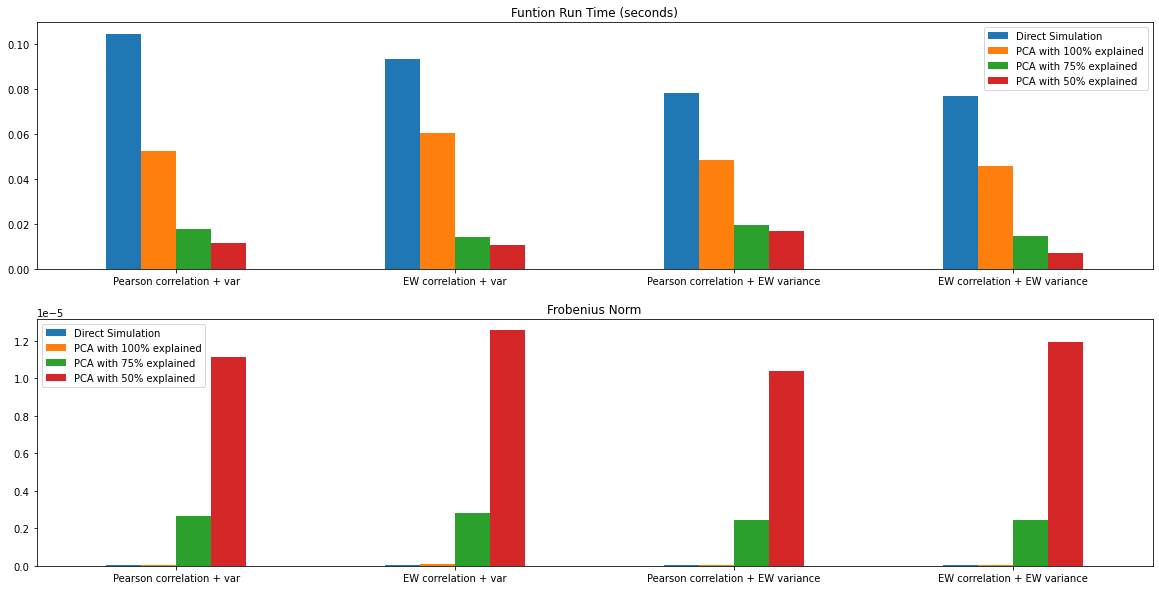

In [24]:
# 4combinations
combi_cov = []
combi_cov.append(cal_cov(oriStd,oriCorr))
combi_cov.append(cal_cov(oriStd,ewCorr))
combi_cov.append(cal_cov(ewStd,oriCorr))
combi_cov.append(cal_cov(ewStd,ewCorr))

methodLabel = ["Pearson correlation + var",
         "EW correlation + var",
         "Pearson correlation + EW variance",
         "EW correlation + EW variance"]

simLabel = ["Direct Simulation",
            "PCA with 100% explained",
            "PCA with 75% explained",
            "PCA with 50% explained"]

#fig, axes = plt.subplots(4,3,figsize = (5*length,3*length))
time_list = []
Norm_list = []
params = [1.0,0.75,0.5]
for i, cov in enumerate(combi_cov):
    timer = []
    Norm = []
    res_direct, time_direct = Function_runtime(Cho_simulate_data, cov, 25000)
    timer.append(time_direct)
    Norm.append(Frobenius_norm(np.cov(res_direct) - cov))
    
    for p in params:
        res_pca, time_pca = Function_runtime(PCA_simulate_data, cov, p,25000)
        timer.append(time_pca)
        Norm.append(Frobenius_norm(np.cov(res_pca) - cov))
    time_list.append(timer)
    Norm_list.append(Norm)
        
    
fig, axes = plt.subplots(2,1,figsize = (3*length,3*length))


TimeSim_pd = pd.DataFrame(time_list,index=methodLabel,columns = simLabel)
NormSim_pd = pd.DataFrame(Norm_list,index=methodLabel,columns = simLabel)

TimeSim_pd.plot.bar(rot = 0,figsize=(20, 10), ax = axes[0],title = "Funtion Run Time (seconds)")
NormSim_pd.plot.bar(rot = 0,figsize=(20, 10), ax = axes[1],title = "Frobenius Norm")
display(TimeSim_pd)
display(NormSim_pd)

# Conclusion for Problem 3
When dealing with a extremely high-dimensional data, the processing speed of the function has to be considered. When applying direct method for simulating time series, we use all the information, so the information loss would be the least but the run time is the longest because the high volume of the data.

However, Principal Component Analysis is dimension reduction technique for high-dimensional data. Although there is a loss of information, there are still many dimensions of data computation that can be reduced by retaining 100% of the information, and the loss of information is not much different from running directly.

So PCA is a very useful tool to reduce the computation of multi-dimensional data. However, when only 75% or even 50% information is selected, although the running time is greatly accelerated, more information will be missing in the generated data.

Therefore, we need to maintain more information while maintaining acceptable uptime is the most important.